In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics.classification import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from textvec import vectorizers

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load data

## 20news

In [3]:
def get_multiclass_20news_data():
    newsgroups_train = fetch_20newsgroups(subset="train")
    newsgroups_test = fetch_20newsgroups(subset="test")
    train_data = pd.DataFrame({"text": newsgroups_train.data, "y": newsgroups_train.target})
    test_data = pd.DataFrame({"text": newsgroups_test.data, "y": newsgroups_test.target})
    return train_data, test_data

In [4]:
news_train, news_test = get_multiclass_20news_data()

## Airline sentiments

In [5]:
def get_airline_multiclass_sentiment_data(path):
    df = pd.read_csv(path, encoding = "ISO-8859-1")
    df.loc[df.airline_sentiment == "negative","airline_sentiment"] = 0
    df.loc[df.airline_sentiment == "positive","airline_sentiment"] = 1
    df.loc[df.airline_sentiment == "neutral","airline_sentiment"] = 2
    X_train, X_test, y_train, y_test = train_test_split(
        df.text, df.airline_sentiment, stratify=df.airline_sentiment, test_size=0.2, random_state=0
    )
    train_data = pd.DataFrame({"text": X_train, "y": y_train})
    test_data = pd.DataFrame({"text": X_test, "y": y_test})
    return train_data, test_data

In [6]:
air_train, air_test = get_airline_multiclass_sentiment_data("/home/enio/Загрузки/data/Airline-Sentiment-2-w-AA.csv")

# Grid search

In [7]:
transformers = [
    ("tf", TfidfTransformer(use_idf=False, sublinear_tf=True)),
    ("tfidf", TfidfTransformer(sublinear_tf=True)),
    ("tficf", vectorizers.TfIcfVectorizer(sublinear_tf=True))
]

In [8]:
param_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "vectorizer__max_features": [2000, 5000, None],
    "clf__C": [0.01, 0.1, 1, 10],
}

In [9]:
def grid_search(param_grid, train, test, n_jobs=-1):
    results = dict()
    
    for name, transformer in transformers:
        pipeline = Pipeline([
            ("vectorizer", CountVectorizer()),
            ("transformer", transformer),
            ("clf", LogisticRegression(solver="saga", random_state=0))
        ])
        search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=n_jobs, scoring="accuracy")
        search.fit(train.text, train.y)

        test_preds_proba = search.best_estimator_.predict_proba(test.text)
        test_preds = np.argmax(test_preds_proba, axis=1)
        np.testing.assert_allclose(test_preds, search.best_estimator_.predict(test.text))

        train_accuracy = search.best_score_
        test_accuracy = accuracy_score(test.y, test_preds)
        print(f"{name:10} train accuracy: {train_accuracy:<15} test accuracy: {test_accuracy}")

        local_results = {
            "best_params": search.best_params_,
            "test_accuracy": test_accuracy,
            "preds_proba": test_preds_proba[:, 1]
        }
        results[name] = local_results
    return results

# Correlation heatmap

In [10]:
def plot_correlation_heatmap(results, title):
    probs = []
    labels = []
    for name, _ in transformers:
        probs.append(results[name]["preds_proba"])
        accuracy = results[name]["test_accuracy"]
        labels.append(f"{name}: {accuracy:.4f}")
    probs = np.array(probs)
    corr = np.corrcoef(probs)

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(corr, 
                     cmap="viridis", 
                     square=True, 
                     annot=corr, 
                     linewidth=0.5,
                     xticklabels=labels,
                     yticklabels=labels)
    ax.set_title(title)
    plt.show()

tf         train accuracy: 0.8059255464480874 test accuracy: 0.8084016393442623
tfidf      train accuracy: 0.8046448087431693 test accuracy: 0.8118169398907104
tficf      train accuracy: 0.8080601092896175 test accuracy: 0.8125


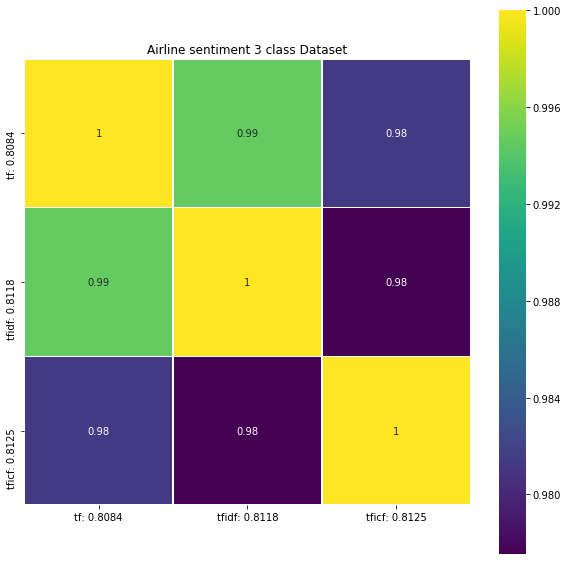

In [13]:
results = grid_search(param_grid, air_train, air_test, n_jobs=4)
plot_correlation_heatmap(results, "Airline sentiment 3 class Dataset")

tf         train accuracy: 0.8980908608803253 test accuracy: 0.820631970260223
tfidf      train accuracy: 0.9272582640975782 test accuracy: 0.8575411577270313
tficf      train accuracy: 0.9129397207000177 test accuracy: 0.8292618162506639


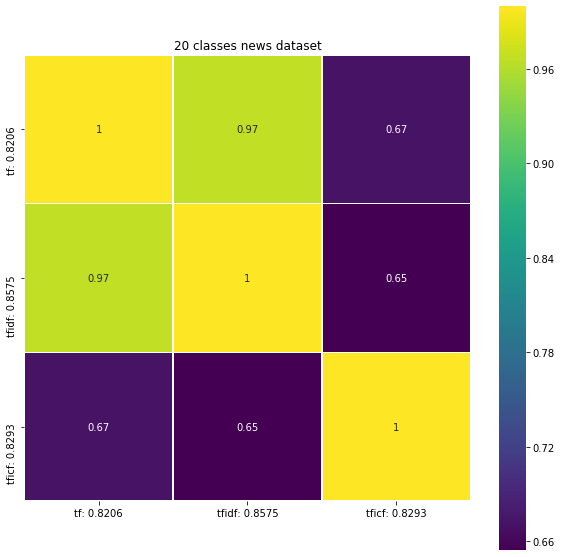

In [12]:
results = grid_search(param_grid, news_train, news_test, n_jobs=3)
plot_correlation_heatmap(results, "20 classes news dataset")